C:\Users\Lvk\AppData\Local\Temp\ipykernel_23128\2823036423.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories)
C:\Users\Lvk\AppData\Local\Temp\ipykernel_23128\2823036423.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["", "", "", "", ""], color="gray", size=18)


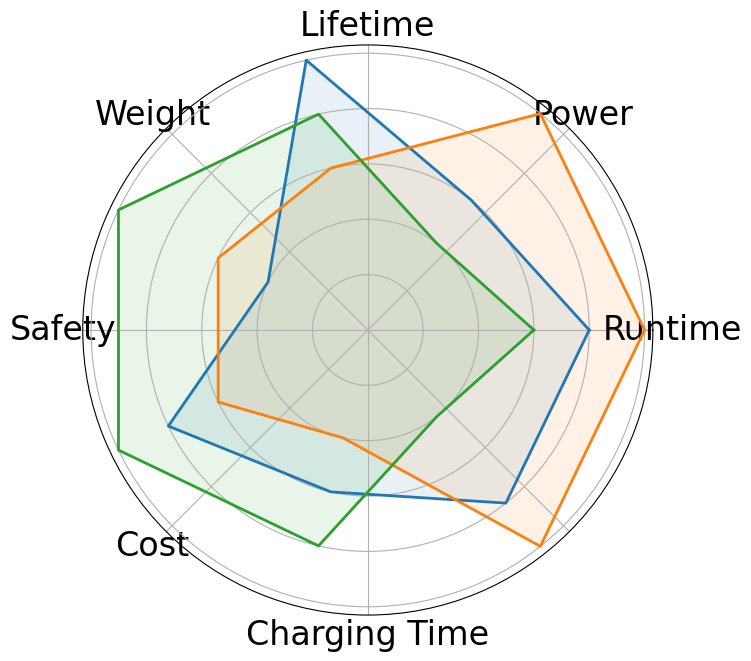

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define categories and number of variables
categories = ['Runtime', 'Power', 'Lifetime', 'Weight', 'Safety', 'Cost', 'Charging Time']
N = len(categories)

# Example data for three battery designs (normalized values)
high_power =    [3, 5, 3, 3, 3, 2, 5, 4]  # Prioritizes power and charging speed
high_energy =   [5, 3, 4, 2, 4, 3, 3, 3]  # Prioritizes runtime and capacity
low_cost =      [3, 3, 3, 3, 3, 5, 3, 5]  # Balanced design with emphasis on cost and scalability


# Repeat the first value to close the circle
values_A = battery_A + [battery_A[0]]
values_B = battery_B + [battery_B[0]]
values_C = battery_C + [battery_C[0]]

# Calculate angle for each category
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Set font size
plt.rcParams.update({'font.size': 24})

# Draw one axis per variable and add labels
# ax.set_theta_offset(np.pi / 2)
# ax.set_theta_direction(-1)
# ax.set_rlabel_position(0)
# ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Draw ylabels
#ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(["", "", "", "", ""], color="gray", size=18)

# Plot data
ax.plot(angles, values_A, label='Design A', linewidth=2)
ax.fill(angles, values_A, alpha=0.1)

ax.plot(angles, values_B, label='Design B', linewidth=2)
ax.fill(angles, values_B, alpha=0.1)

ax.plot(angles, values_C, label='Design C', linewidth=2)
ax.fill(angles, values_C, alpha=0.1)

# Add legend
# ax.legend(loc='best', bbox_to_anchor=(1.3, 1.1), fontsize=20)

plt.tight_layout()
plt.show()
